# This cell contains the inducing point experiment
Rather than picking random inducing points, instead we pick only zeros for the zero-predicting GP, ones for the one-predicting GP, etc.
We see a significant decrease in accuracy, and barely any change in the inducing points for some classes.

In [2]:
import gpytorch, torch, torchvision
import torchvision.transforms as transforms
from numpy.random import choice
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gpytorch.models import ApproximateGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import CholeskyVariationalDistribution, MeanFieldVariationalDistribution, VariationalStrategy, MultitaskVariationalStrategy
from gpytorch.likelihoods import SoftmaxLikelihood
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from gpytorch.means import ConstantMean

np.random.seed(5)
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 5)

## Defining the model
The model uses 10 latent functions, one for the output of each class, each with its own inducing points. These functions are independent a priori, but are linked together by the Softmax layer and the inducing points learned for each layer.

Each image is flattened into a single vector rather than a matrix.

In [3]:
class RBFClassificationModel(ApproximateGP):
    def __init__(self, inducing_points):
        self.num_tasks = inducing_points.shape[0]
        self.M = inducing_points.shape[-2]
        var_dist = MeanFieldVariationalDistribution(self.M, batch_shape=torch.Size([self.num_tasks]))
        var_strat = MultitaskVariationalStrategy(VariationalStrategy(self, inducing_points, var_dist), self.num_tasks)
        super(RBFClassificationModel, self).__init__(var_strat)
        self.mean_module = ConstantMean(batch_shape=torch.Size([self.num_tasks]))
        self.covar_module = ScaleKernel(RBFKernel(batch_shape=torch.Size([self.num_tasks])), batch_shape=torch.Size([self.num_tasks]))# batch_shape=(inducing_points.shape[0]+batch_size) # ScaleKernel(RBFKernel()) #

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        latent_pred = MultitaskMultivariateNormal(mean, covar)
        return latent_pred

## Loading the data
Here a batch size of 50 is chosen, and a train and test set are created.

In [4]:
batch_size = 50
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## Instantiating the model
10 batches of 200 inducing points are randomly chosen from the training data and used to instantiate the model. Everything is moved to the GPU. To optimize the variational parameters (and the inducing points), we maximize the ELBO which is equivalent to minimizing the KL divergence.

In [5]:
def isfull(d, n):
    for k in d.keys():
        if len(d[k]) != n: return False
        
    return True

In [19]:
from collections import defaultdict
img_shape = (28, 28)
n_channels = 1
n_classes = 10
n_epochs = 5
n_inducing = 200

inducing_points = defaultdict(list)
for i in range(len(trainset)):
    x, y = trainset[i]
    x = x.reshape(-1)[None,:]
    if len(inducing_points[int(y)]) < n_inducing: inducing_points[int(y)].append(x)
    if isfull(inducing_points, n_inducing): break

inducing_points = torch.cat([torch.cat(inducing_points[i])[None,:] for i in range(n_classes)])   
model = RBFClassificationModel(inducing_points).cuda()
likelihood = SoftmaxLikelihood(num_features=n_classes, num_classes=n_classes).cuda()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(trainset))
optim = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()))

torch.Size([1, 784])

## Training the model
Here we use 5 epochs to train the model rather arbitrarily; the epochs are very quick and more could easily be used.

In [20]:
model.train()
likelihood.train()

with gpytorch.settings.lazily_evaluate_kernels(False):
    for i in range(n_epochs):
        train_iter = tqdm(trainloader)
        train_iter.set_description(f'Epoch {i+1} of {n_epochs}')
        for x, y in train_iter:
            x = x.reshape(x.shape[0], -1)
            x = x.cuda(); y = y.cuda()
            optim.zero_grad()
            output = model(x)
            loss = -mll(output, y)
            loss.backward()
            train_iter.set_postfix(loss=loss.item())
            optim.step()
            
print(f'Final loss: {round(loss.item(),3)}')


Final loss: 1.121


## Testing the model
Here we draw 20 samples from the Softmax likelihood for each test input, average over them, and pick the highest probability among them to compare to the test output.

In [21]:
model.eval()
likelihood.eval()

correct = 0
test_iter = tqdm(testloader)
with torch.no_grad(), gpytorch.settings.lazily_evaluate_kernels(False), gpytorch.settings.num_likelihood_samples(20):
    for i, (x, y) in enumerate(test_iter,1):
        x = x.reshape(x.shape[0], -1)
        x = x.cuda(); y = y.cuda()
        pred = likelihood(model(x))
        pred = pred.probs.mean(0).argmax(-1)
        correct += int(pred.eq(y.view_as(pred)).cpu().sum())
        test_iter.set_postfix(acc=(correct/(i*batch_size)))
        
print(f'Accuracy: {round(correct/len(testset), 3)}')


Accuracy: 0.675


## Visualizing the posterior
Here I picked some images the model had more trouble with.

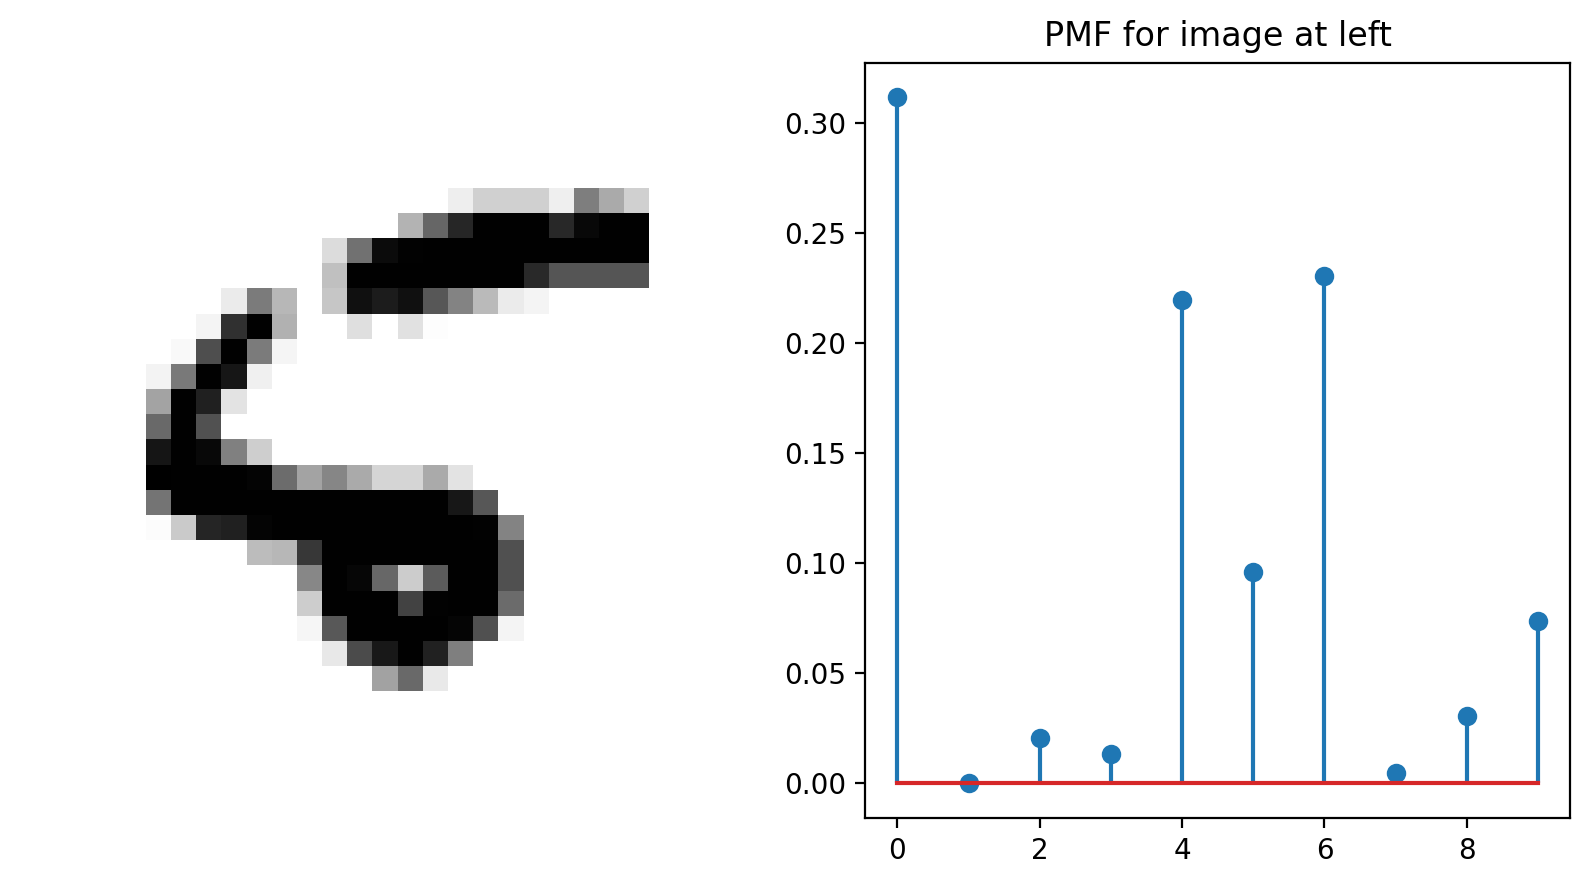

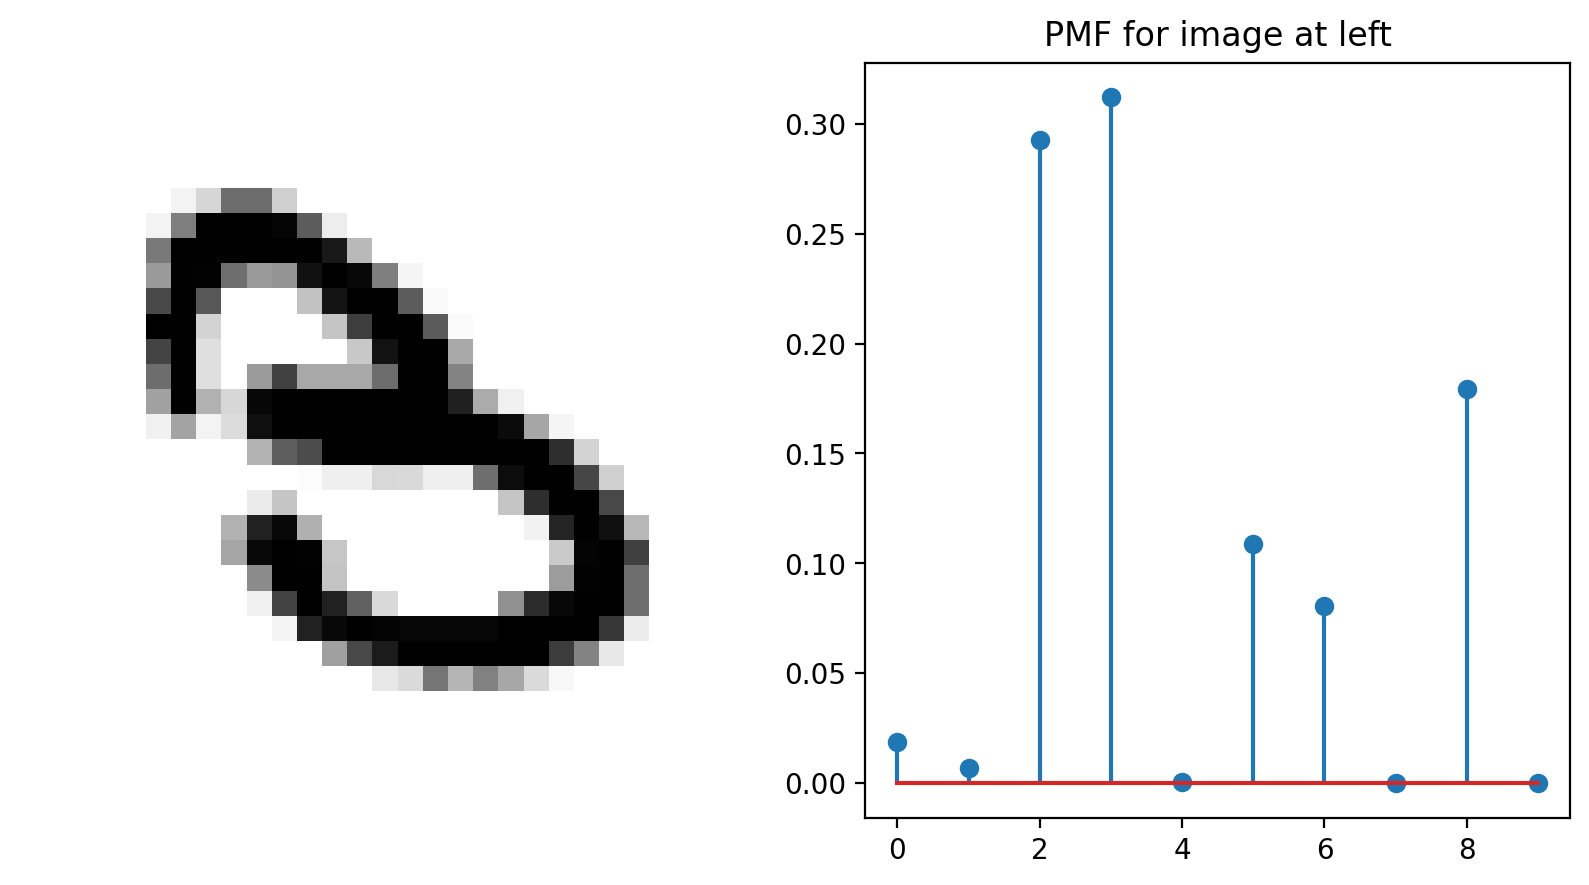

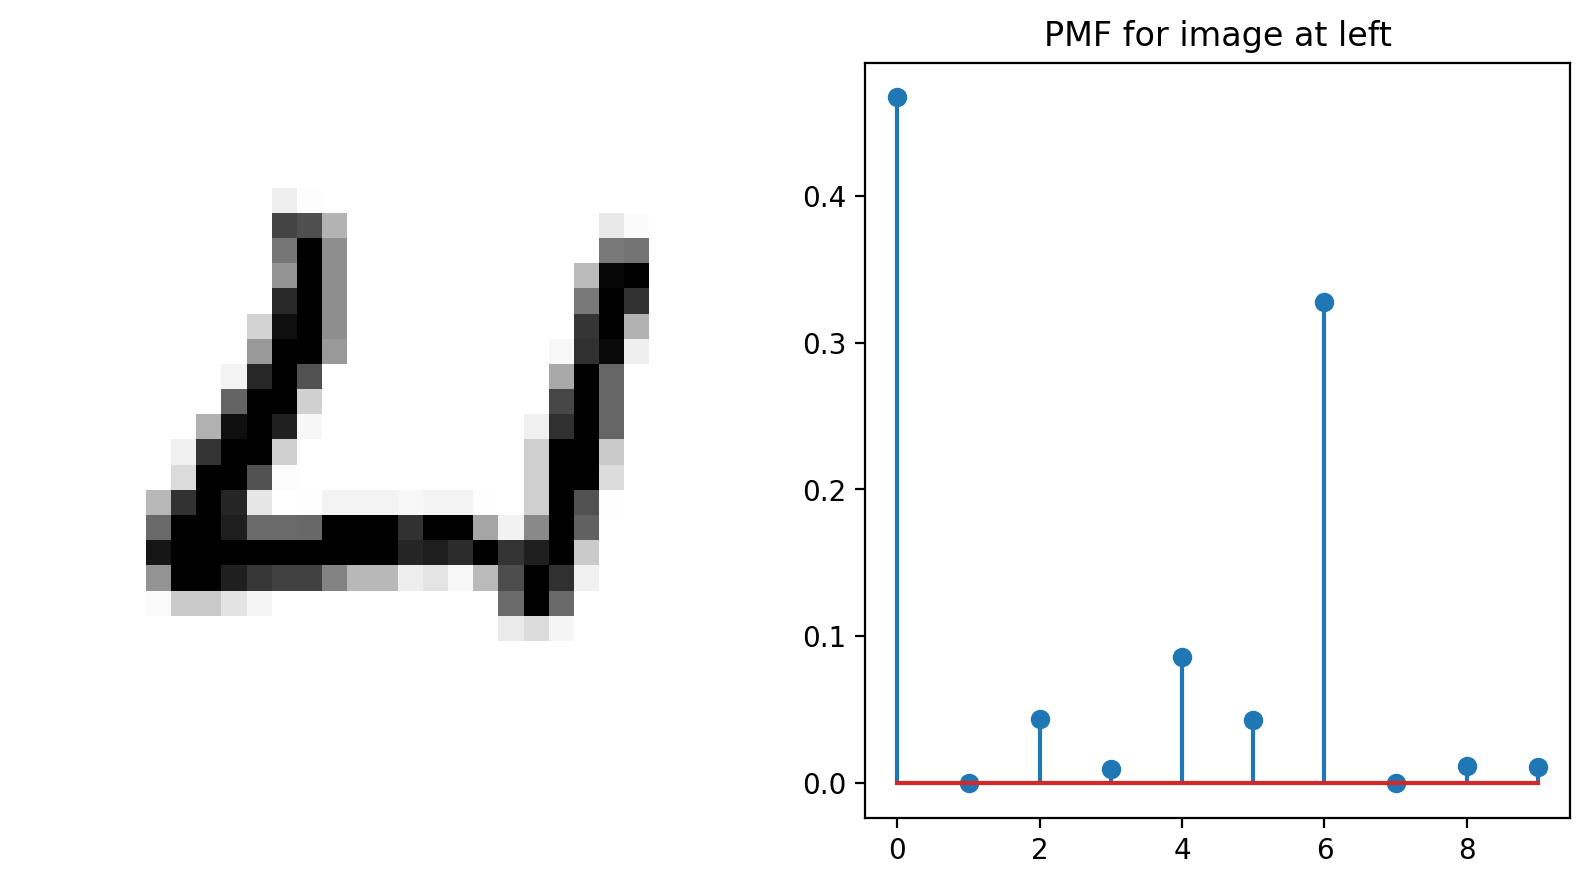

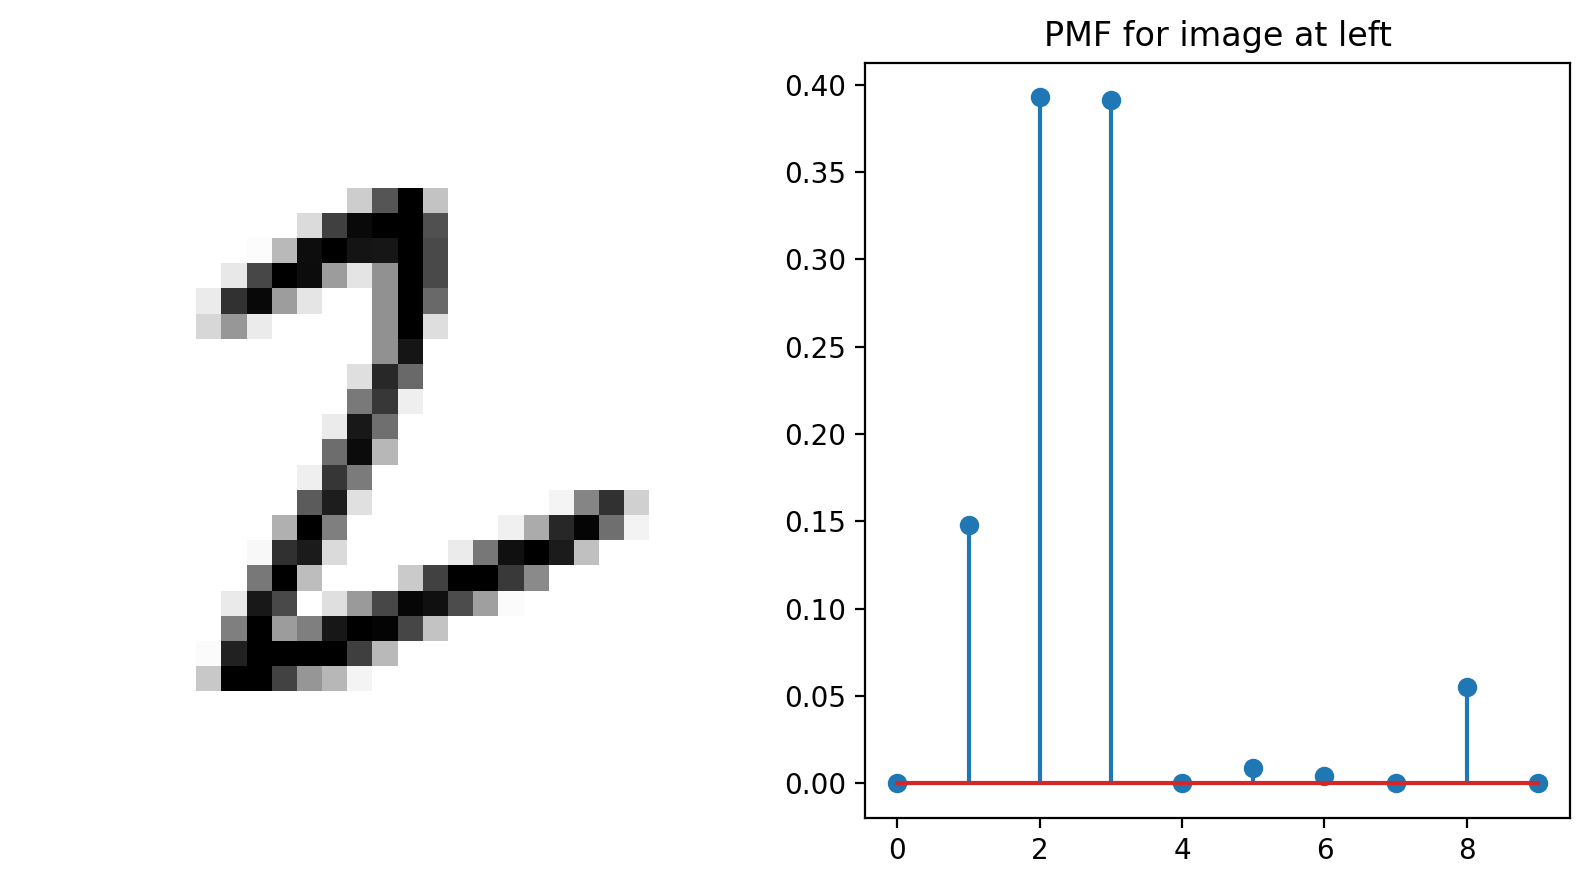

In [22]:
for i in [8,18,33,38]:
    x, _ = testset[i]
    fig, axes = plt.subplots(1,2)
    fig.set_size_inches((10,5))
    fig.set_dpi(200)
    axes[0].imshow(x[0], cmap='binary')
    axes[0].axis('off')
    x = x.reshape(x.shape[0],-1).cuda()
    pred = likelihood(model(x))
    dist = pred.probs.mean(0).cpu().detach().numpy()[0]
    axes[1].stem(dist)
    plt.title('PMF for image at left')
    plt.show()

## Visualizing learning of the inducing points
Interestingly, the learning of the inducing points gives us a little insight into the structure that the RBF and GP are able to capture in the image. Below are plots of the inducing points (left before training, right after training), and we can see that for each class, the inducing points are "mutated" to be more similar to the desired output. 

For instance, if we look at the inducing points for the (0 class), we can see that many of the 6's and 2's in the initial inducing points have been significantly mutated to look more like zeros after training.

Latent function inducing points predicting 0, before and after training


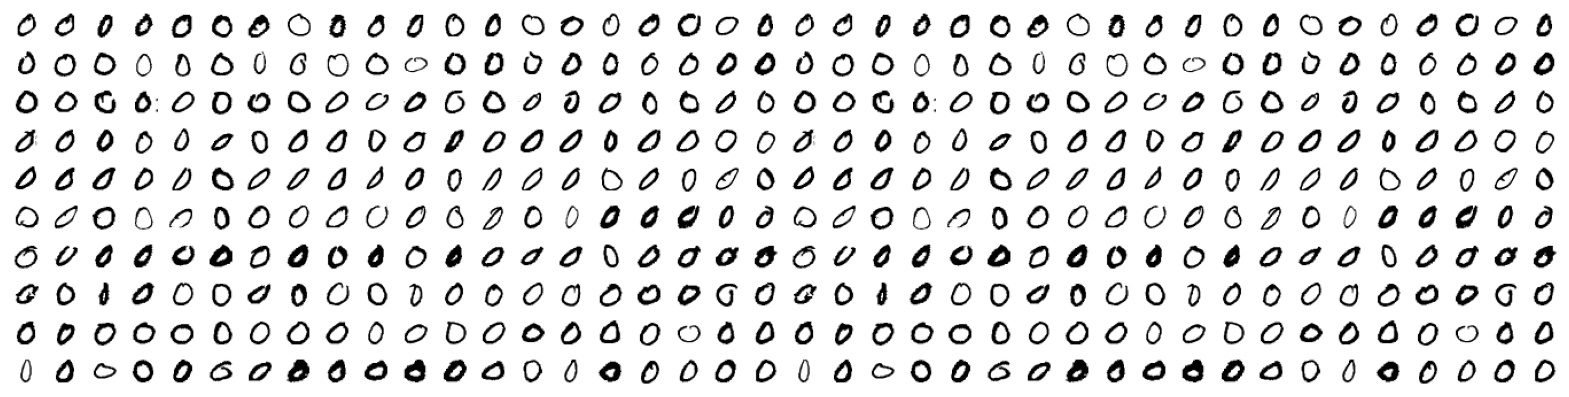

Latent function inducing points predicting 1, before and after training


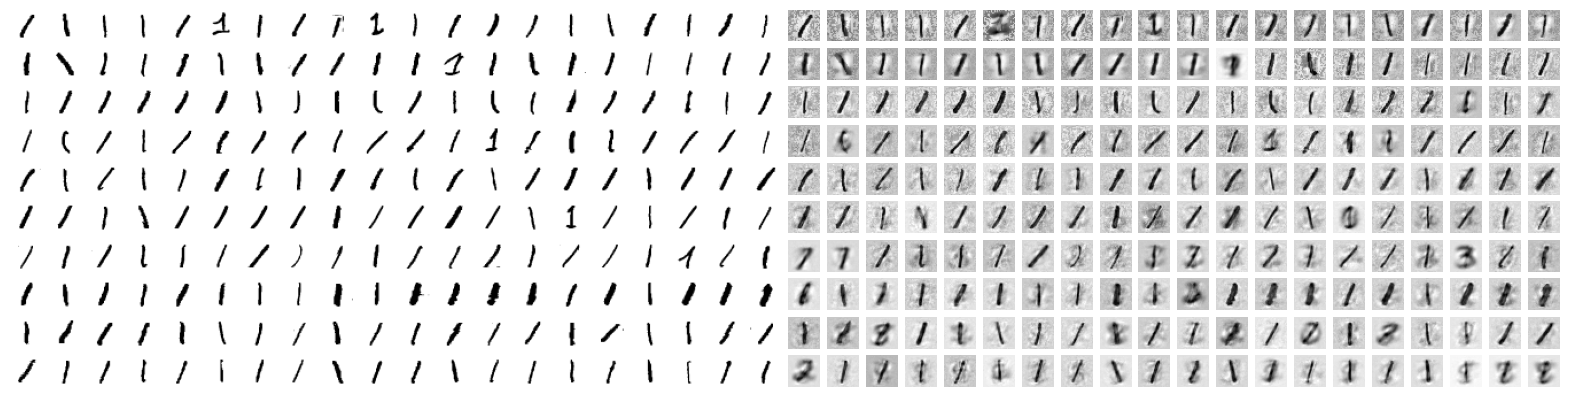

Latent function inducing points predicting 2, before and after training


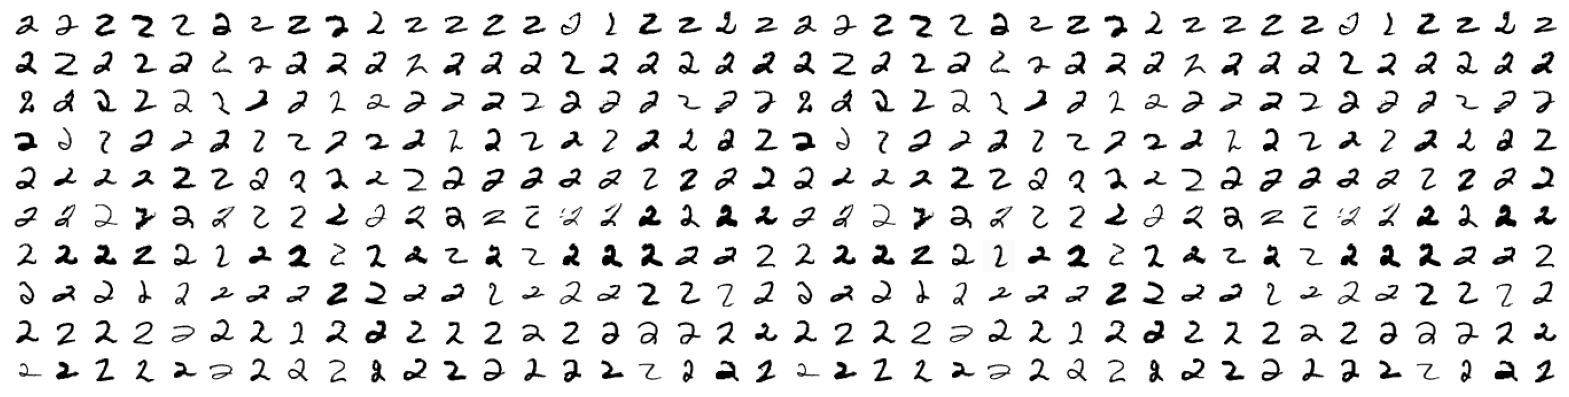

Latent function inducing points predicting 3, before and after training


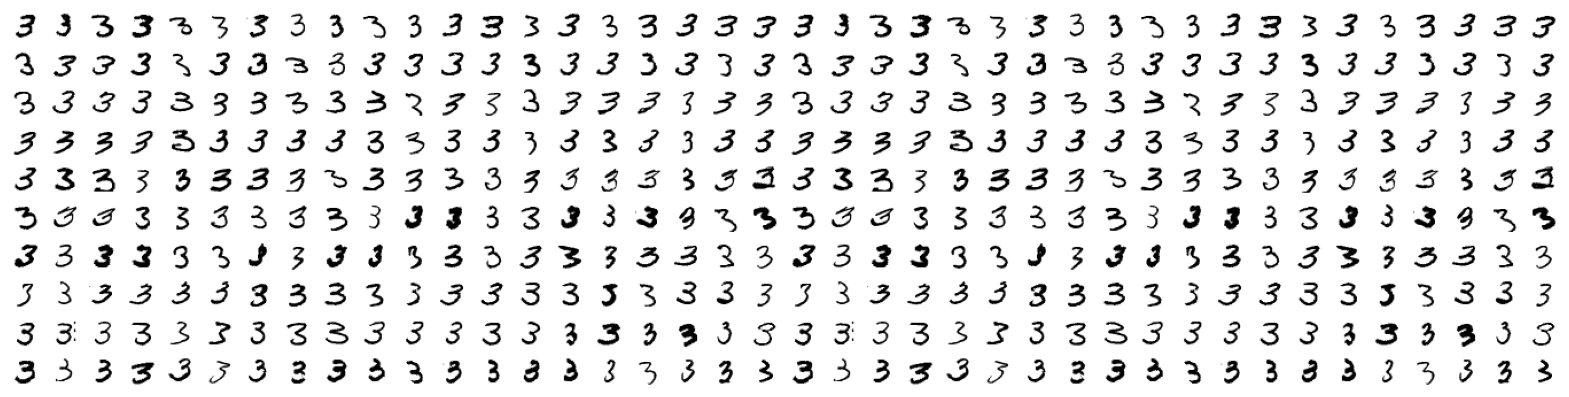

Latent function inducing points predicting 4, before and after training


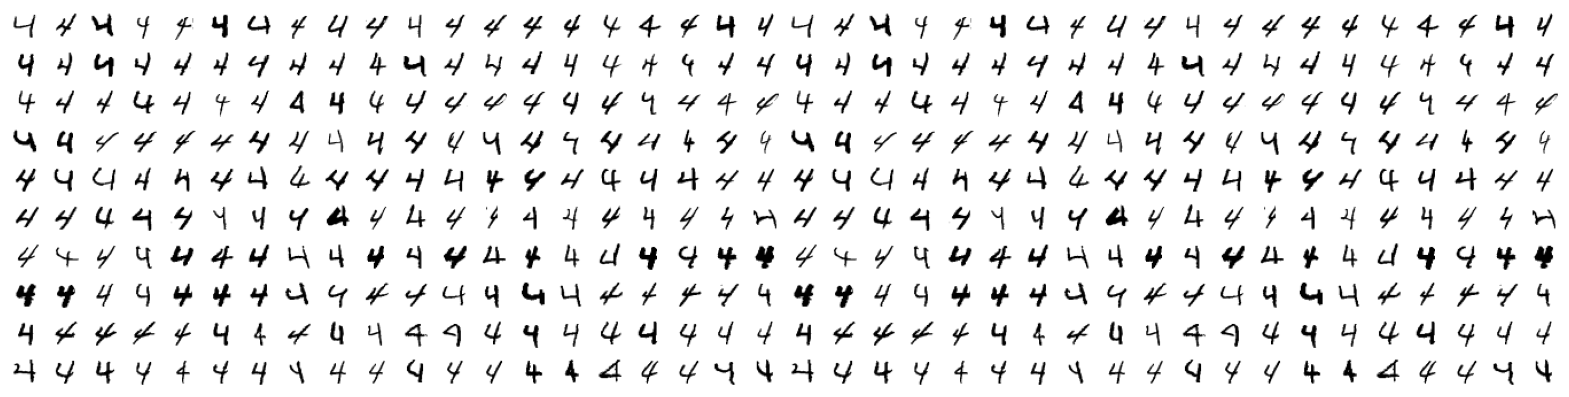

Latent function inducing points predicting 5, before and after training


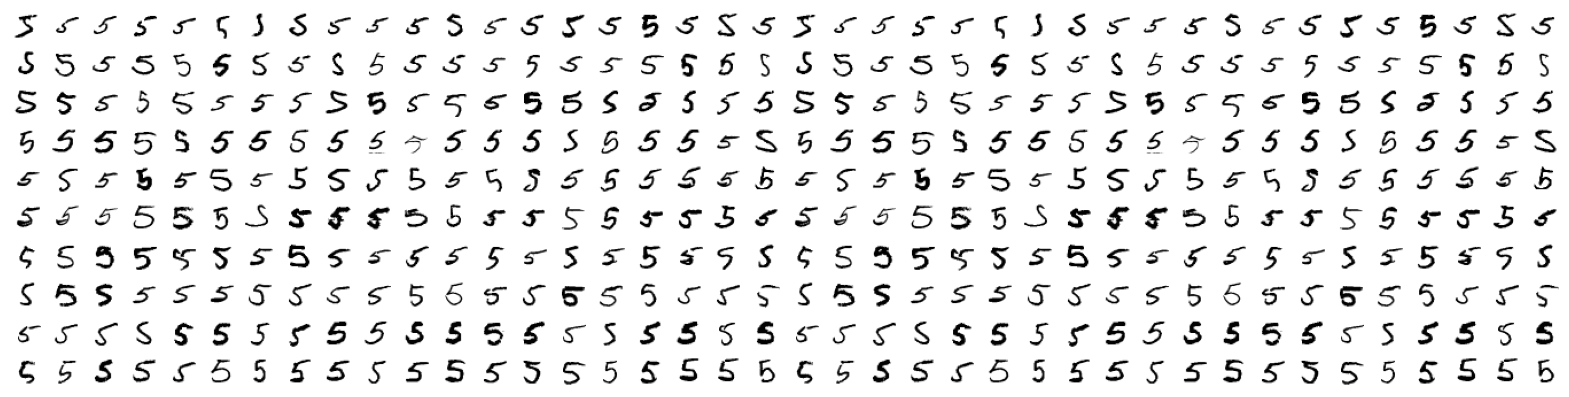

Latent function inducing points predicting 6, before and after training


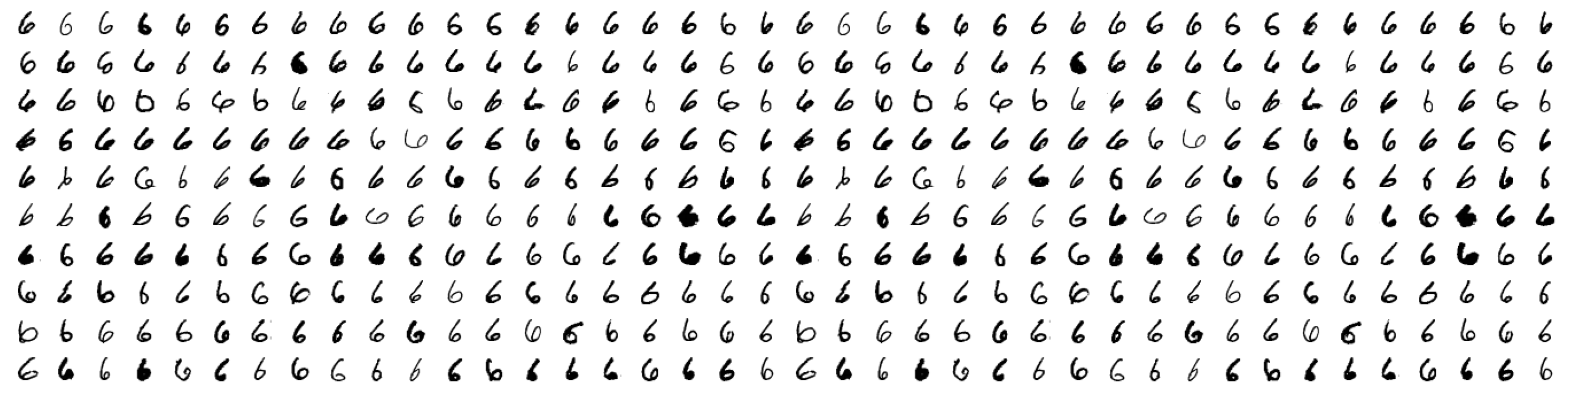

Latent function inducing points predicting 7, before and after training


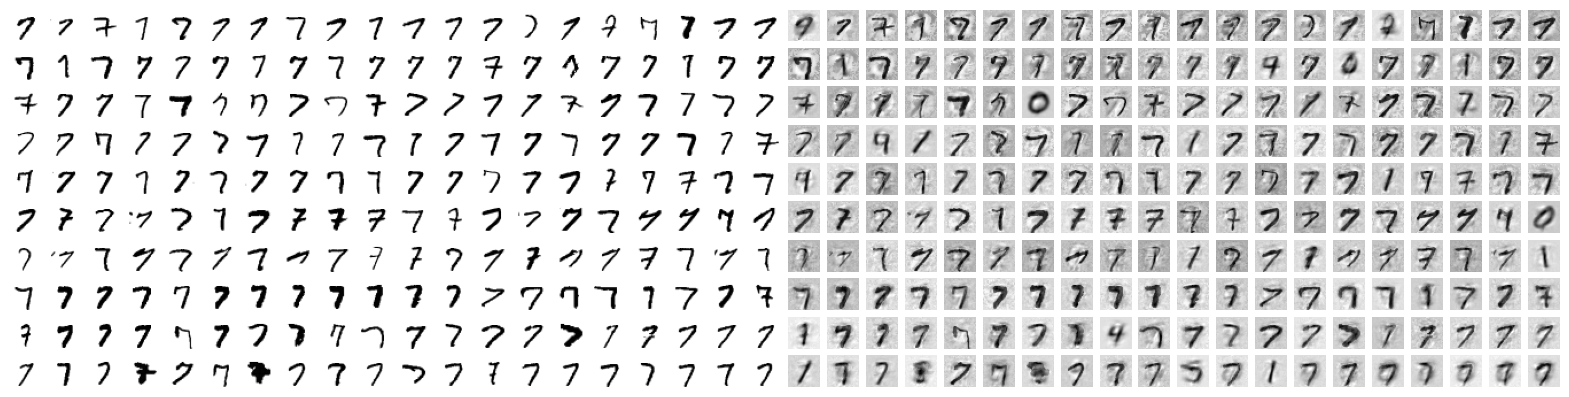

Latent function inducing points predicting 8, before and after training


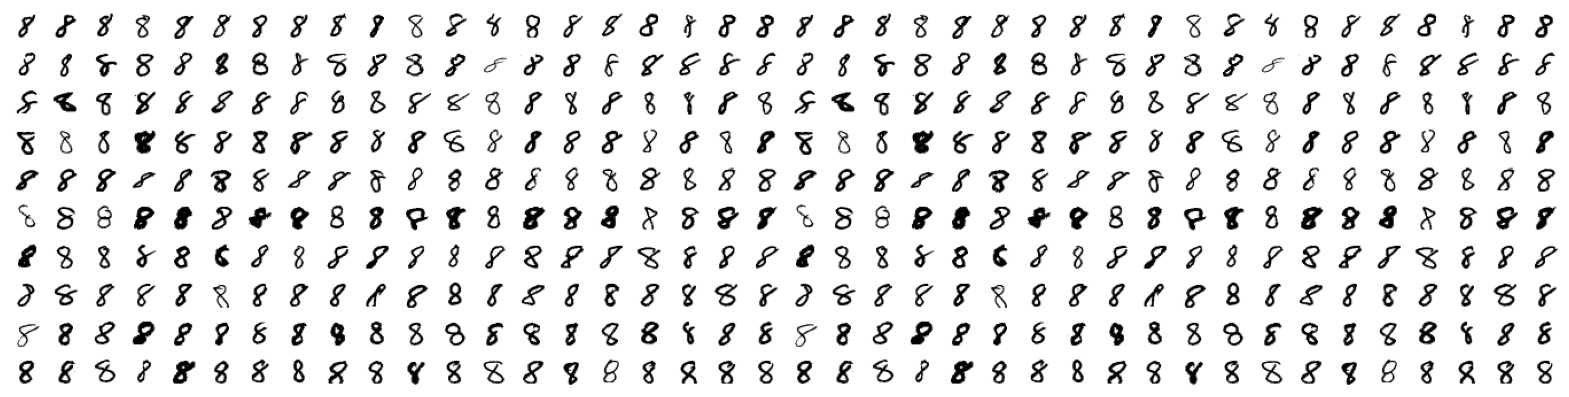

Latent function inducing points predicting 9, before and after training


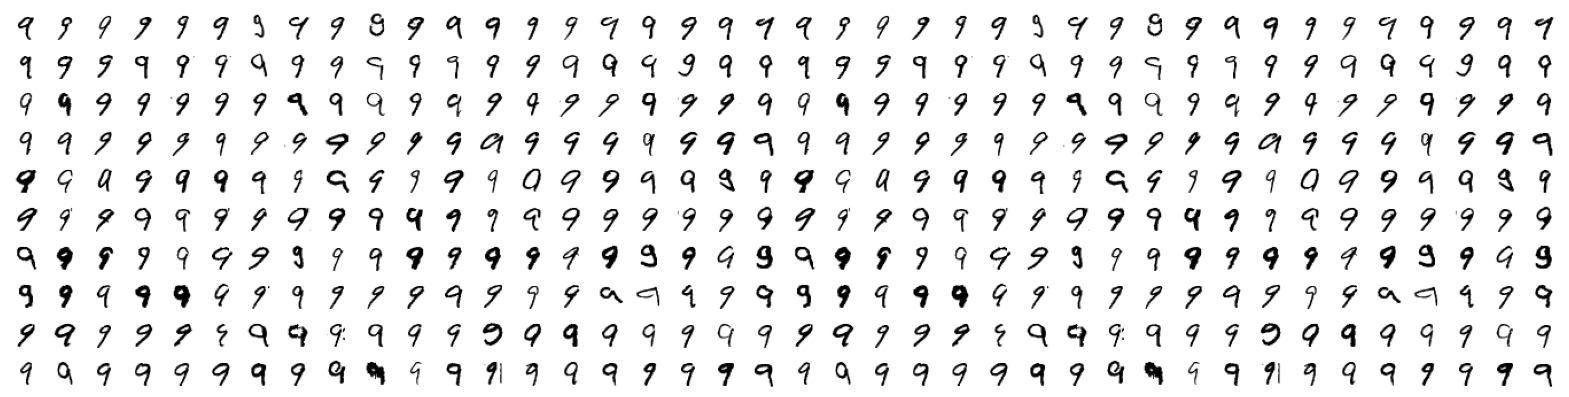

In [23]:
ind_cpu_pre = inducing_points.cpu()
ind_cpu_post = list(model.parameters())[0].cpu().detach().numpy()
for j in range(n_classes):
    print(f'Latent function inducing points predicting {j}, before and after training')
    fig, axes = plt.subplots(10,40)
    fig.set_dpi(100)
    for i in range(n_inducing):
        x = i // 20
        y = i % 20
        axes[x][y].imshow(ind_cpu_pre[j][i].reshape(img_shape), cmap='binary')
        axes[x][y].axis('off')
        
    for i in range(n_inducing):
        x = i // 20
        y = i % 20 + 20
        axes[x][y].imshow(ind_cpu_post[j][i].reshape(img_shape), cmap='binary')
        axes[x][y].axis('off')
    plt.show()